In [1]:
def load_pose(pose_txt):
    pose = []
    with open(pose_txt, 'r') as f:
        for line in f:
            row = line.strip('\n').split()
            row = [float(c) for c in row]
            pose.append(row)
    pose = np.array(pose).astype(np.float32)
    assert pose.shape == (4,4)
    return pose

In [2]:
import csv
import glob
import os

import cv2
import numpy as np
import torch
import trimesh
from PIL import Image
from pathlib import Path

import sys
# 假设你的项目根目录路径是 '/path/to/your/project'
project_root = 'D:/gs-localization'

# 将项目根目录添加到 sys.path 中
if project_root not in sys.path:
    sys.path.append(project_root)

# 验证路径是否已成功添加
from gaussian_splatting.utils.graphics_utils import focal2fov

try:
    import pyrealsense2 as rs
except Exception:
    pass

class BaseDataset(torch.utils.data.Dataset):
    def __init__(self, args, path, config):
        self.args = args
        self.path = path
        self.config = config
        self.device = "cuda:0"
        self.dtype = torch.float32
        self.num_imgs = 999999

    def __len__(self):
        return self.num_imgs

    def __getitem__(self, idx):
        pass

class MonocularDataset(BaseDataset):
    def __init__(self, args, path, config):
        super().__init__(args, path, config)
        calibration = config["Dataset"]["Calibration"]
        # Camera prameters
        self.fx = calibration["fx"]
        self.fy = calibration["fy"]
        self.cx = calibration["cx"]
        self.cy = calibration["cy"]
        self.width = calibration["width"]
        self.height = calibration["height"]
        self.fovx = focal2fov(self.fx, self.width)
        self.fovy = focal2fov(self.fy, self.height)
        self.K = np.array(
            [[self.fx, 0.0, self.cx], [0.0, self.fy, self.cy], [0.0, 0.0, 1.0]]
        )
        # distortion parameters
        self.disorted = calibration["distorted"]
        self.dist_coeffs = np.array(
            [
                calibration["k1"],
                calibration["k2"],
                calibration["p1"],
                calibration["p2"],
                calibration["k3"],
            ]
        )
        self.map1x, self.map1y = cv2.initUndistortRectifyMap(
            self.K,
            self.dist_coeffs,
            np.eye(3),
            self.K,
            (self.width, self.height),
            cv2.CV_32FC1,
        )
        # depth parameters
        self.has_depth = True if "depth_scale" in calibration.keys() else False
        self.depth_scale = calibration["depth_scale"] if self.has_depth else None

        # Default scene scale
        nerf_normalization_radius = 5
        self.scene_info = {
            "nerf_normalization": {
                "radius": nerf_normalization_radius,
                "translation": np.zeros(3),
            },
        }

    def __getitem__(self, idx):
        color_path = self.color_paths[idx]
        pose = self.poses[idx]

        image = np.array(Image.open(color_path))
        depth = None

        if self.disorted:
            image = cv2.remap(image, self.map1x, self.map1y, cv2.INTER_LINEAR)

        if self.has_depth:
            depth_path = self.depth_paths[idx]
            depth = np.array(Image.open(depth_path)) / self.depth_scale

        image = (
            torch.from_numpy(image / 255.0)
            .clamp(0.0, 1.0)
            .permute(2, 0, 1)
            .to(device=self.device, dtype=self.dtype)
        )
        pose = torch.from_numpy(pose).to(device=self.device)
        return image, depth, pose


class v2_360_Dataset(MonocularDataset):
    def __init__(self, args, path, config, data_folder, scene):
        super().__init__(args, path, config)
        self.has_depth = False
        self.v2_360_Parser(data_folder, scene) 
        
    def v2_360_Parser(self, data_folder, scene):
        self.color_paths, self.poses, self.depth_paths = [], [], []

        gt_dirs = Path(data_folder) / scene / "sparse/0"
        cameras, images, points3D = read_write_model.read_model(gt_dirs, ".bin")

        test_images = Path(data_folder) / scene / "train_views/triangulated/list_test.txt"
        name2id = {image.name: i for i, image in images.items()}

        with open(test_images, "r") as f:
            while True:
                image_name = f.readline()
                if not image_name:
                    break
                image_name = image_name.strip()
                if len(image_name) > 0 and image_name[0] != "#":
                    image_path = Path(data_folder) / scene / f"images_4/{image_name}"
                    self.color_paths.append(image_path)

                    image = images[name2id[image_name]]
                    R_gt, t_gt = image.qvec2rotmat(), image.tvec
                    pose = np.eye(4)            
                    pose[:3, :3] = R_gt         
                    pose[:3, 3] = t_gt 
                    self.poses.append(pose)


In [5]:
import os
import sys
import time
from argparse import ArgumentParser
from datetime import datetime

import torch
import torch.multiprocessing as mp
import yaml
import numpy as np
from munch import munchify

import sys
sys.path.append("D:/gs-localization/gaussian_splatting")
sys.path.append("D:/gs-localization")
import wandb
from tools.gaussian_model import GaussianModel
from gaussian_splatting.utils.system_utils import mkdir_p
from tools.config_utils import load_config
from tools.multiprocessing_utils import FakeQueue
from tools import read_write_model

In [6]:
def update_recursive(dict1, dict2):
    """
    Update two config dictionaries recursively. dict1 get masked by dict2, and we retuen dict1.

    Args:
        dict1 (dict): first dictionary to be updated.
        dict2 (dict): second dictionary which entries should be used.
    """
    for k, v in dict2.items():
        if k not in dict1:
            dict1[k] = dict()
        if isinstance(v, dict):
            update_recursive(dict1[k], v)
        else:
            dict1[k] = v


In [7]:
with open("C:/Users/27118/Desktop/master_project/MonoGS/configs/mono/tum/fr3_office.yaml", "r") as f:
    cfg_special = yaml.full_load(f)

inherit_from = "C:/Users/27118/Desktop/master_project/MonoGS/configs/mono/tum/base_config.yaml"

if inherit_from is not None:
    cfg = load_config(inherit_from)
else:
    cfg = dict()

# merge per dataset cfg. and main cfg.
config = update_recursive(cfg, cfg_special)
config = cfg

def set_config(tr_dirs, config):
    cameras, _, _ = read_write_model.read_model(tr_dirs, ".bin")
    config["Dataset"]["dataset_path"] = tr_dirs
    config["Dataset"]["Calibration"]["fx"] = cameras[1][4][0]
    config["Dataset"]["Calibration"]["fy"] = cameras[1][4][1]
    config["Dataset"]["Calibration"]["cx"] = cameras[1][4][2]
    config["Dataset"]["Calibration"]["cy"] = cameras[1][4][3]
    config["Dataset"]["Calibration"]["width"] = cameras[1][2]
    config["Dataset"]["Calibration"]["height"] = cameras[1][3]
    return config
    
data_folder = "D:/gs-localization/datasets/360_v2"
scene = "stump"
tr_dirs = Path(data_folder) / scene / "train_views/triangulated"
config = set_config(tr_dirs, config)


In [8]:
Model = GaussianModel(3, config)
#Model.load_ply("C:/Users/27118/Desktop/master_project/RaDe-GS/output/26b22380-1/point_cloud/iteration_30000/point_cloud.ply")
#Model.load_ply("D:/gaussian-splatting/output/bycicle/point_cloud/iteration_7000/point_cloud.ply")
Model.load_ply(f"D:/gs-localization/output/360_v2/{scene}/gs_map/iteration_20000/point_cloud.ply")


In [9]:
config["model_params"]

{'sh_degree': 0,
 'source_path': '',
 'model_path': '',
 'resolution': -1,
 'white_background': False,
 'data_device': 'cuda'}

In [10]:
model_params = munchify(config["model_params"])
pipeline_params = munchify(config["pipeline_params"])
data_folder = "D:/gs-localization/datasets/360_v2"
dataset = v2_360_Dataset(model_params, model_params.source_path, config, data_folder, scene)
bg_color = [0, 0, 0] 
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
dataset[0][0].shape

torch.Size([3, 825, 1245])

In [11]:
data_folder

'D:/gs-localization/datasets/360_v2'

In [12]:
from gaussian_splatting.utils.graphics_utils import getProjectionMatrix2, getWorld2View2
from tools import render
from tools.slam_utils import image_gradient, image_gradient_mask
from tools.camera_utils import Camera
from tools.slam_utils import get_loss_tracking, get_median_depth
from tools.pose_utils import update_pose

In [13]:
projection_matrix = getProjectionMatrix2(
    znear=0.01,
    zfar=100.0,
    fx=dataset.fx,
    fy=dataset.fy,
    cx=dataset.cx,
    cy=dataset.cy,
    W=dataset.width,
    H=dataset.height,
).transpose(0, 1)
projection_matrix = projection_matrix.to(device="cuda:0")

In [14]:
def convert_scaled_to_original_coords(scaled_coords_lst, original_size, scaled_size):
    original_coords_lst = []
    for scaled_coords in scaled_coords_lst:
        original_width, original_height = original_size
        scaled_width, scaled_height = scaled_size
    
        scale_x = original_width / scaled_width
        scale_y = original_height / scaled_height
    
        # 向量化操作
        original_coords = scaled_coords * [scale_x, scale_y]
        original_coords_lst.append(original_coords)

    return original_coords_lst

def create_mask(mkpts_lst, width, height, k):
    # 初始化 mask，全为 False
    mask = np.zeros((height, width), dtype=bool)
    
    # 计算 k 的半径
    half_k = k // 2
    
    # 遍历所有点
    for pt in mkpts_lst:
        x, y = int(pt[0]), int(pt[1])
        
        # 计算 k*k 区域的边界
        x_min = max(0, x - half_k)
        x_max = min(width, x + half_k + 1)
        y_min = max(0, y - half_k)
        y_max = min(height, y + half_k + 1)
        
        # 设置 mask 中的 k*k 区域为 True
        mask[y_min:y_max, x_min:x_max] = True
    
    # 形状为 (1, height, width)
    mask = mask[np.newaxis, :, :]
    
    return mask


"""
mkpts_lst = convert_scaled_to_original_coords(fine_level_mkpts_lst[0], original_size=[1296,968], scaled_size=[640,480])

mask = create_mask(mkpts_lst=mkpts_lst, width=1296, height=968, k=30)
"""

'\nmkpts_lst = convert_scaled_to_original_coords(fine_level_mkpts_lst[0], original_size=[1296,968], scaled_size=[640,480])\n\nmask = create_mask(mkpts_lst=mkpts_lst, width=1296, height=968, k=30)\n'

In [15]:
config["Training"]["opacity_threshold"] = 0.99
from time import time
def gradient_decent(viewpoint, config, initial_R, initial_T):

    viewpoint.update_RT(initial_R, initial_T)
    
    opt_params = []
    opt_params.append(
        {
            "params": [viewpoint.cam_rot_delta],
            "lr": 0.0001,
            "name": "rot_{}".format(viewpoint.uid),
        }
    )
    opt_params.append(
        {
            "params": [viewpoint.cam_trans_delta],
            "lr": 0.001,
            "name": "trans_{}".format(viewpoint.uid),
        }
    )
    opt_params.append(
        {
            "params": [viewpoint.exposure_a],
            "lr": 0.001,
            "name": "exposure_a_{}".format(viewpoint.uid),
        }
    )
    opt_params.append(
        {
            "params": [viewpoint.exposure_b],
            "lr": 0.001,
            "name": "exposure_b_{}".format(viewpoint.uid),
        }
    )
    

    pose_optimizer = torch.optim.Adam(opt_params)
    
    for tracking_itr in range(100):
        
        render_pkg = render(
            viewpoint, Model, pipeline_params, background
        )
        
        image, depth, opacity = (
            render_pkg["render"],
            render_pkg["depth"],
            render_pkg["opacity"],
        )
        
        
        pose_optimizer.zero_grad()
        
        loss_tracking = get_loss_tracking(
            config, image, depth, opacity, viewpoint
        )
        loss_tracking.backward()
        
    
        with torch.no_grad():
            pose_optimizer.step()
            converged = update_pose(viewpoint, converged_threshold=1e-4)
    
        if converged:
            print("converged")
            break
        
            
    return viewpoint.R, viewpoint.T, render_pkg

"""
_,_,render_pkg = gradient_decent(viewpoint, config, initial_R, initial_T)
"""

'\n_,_,render_pkg = gradient_decent(viewpoint, config, initial_R, initial_T)\n'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00035242943..1.9534678].


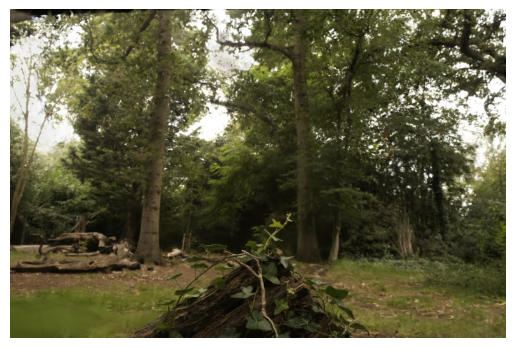

In [26]:
import matplotlib.pyplot as plt
config["Training"]["opacity_threshold"] = 0.99
viewpoint = Camera.init_from_dataset(dataset,13, projection_matrix)

viewpoint.update_RT(viewpoint.R_gt, viewpoint.T_gt)
render_pkg = render(viewpoint, Model, pipeline_params, background)


orig = render_pkg["render"].detach()

# Convert the tensor to a NumPy array
orig = np.array(orig.cpu())

# Transpose the dimensions to [640, 480, 3]
orig = np.transpose(orig, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(orig)
plt.axis('off')  # Hide axes
plt.show()

In [17]:
projection_matrix

tensor([[ 1.8194,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  2.7443,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0001,  1.0000],
        [ 0.0000,  0.0000, -0.0100,  0.0000]], device='cuda:0')

In [18]:
viewpoint = Camera.init_from_dataset(dataset, 0, projection_matrix)
viewpoint.compute_grad_mask(config)
config["Training"]["monocular"] = True
rotation_matrix, translation_vector, render_pkg = gradient_decent(viewpoint, config, viewpoint.R_gt, viewpoint.T_gt)

converged


In [19]:
viewpoint = Camera.init_from_dataset(dataset, 0, projection_matrix)
viewpoint.T_gt

tensor([-0.4622, -2.0641,  3.3221], device='cuda:0', dtype=torch.float64)

In [20]:
import numpy as np
from collections import defaultdict

class Transformation:
    def __init__(self, R=None, T=None):
        self.R = R
        self.T = T

test_infos = defaultdict(Transformation)

def quat_to_rotmat(qvec):
    qvec = np.array(qvec, dtype=float)
    w, x, y, z = qvec
    R = np.array([
        [1 - 2*y**2 - 2*z**2, 2*x*y - 2*z*w, 2*x*z + 2*y*w],
        [2*x*y + 2*z*w, 1 - 2*x**2 - 2*z**2, 2*y*z - 2*x*w],
        [2*x*z - 2*y*w, 2*y*z + 2*x*w, 1 - 2*x**2 - 2*y**2]
    ])
    return R

with open(f"D:/gs-localization/output/360_v2/{scene}/results_sparse.txt", "r") as f:
    for line in f:
        parts = line.strip().split()
        name = parts[0]
        qvec = list(map(float, parts[1:5]))
        tvec = list(map(float, parts[5:8]))

        R = quat_to_rotmat(qvec)
        T = np.array(tvec)

        test_infos[name].R = R
        test_infos[name].T = T

In [21]:
import numpy as np

def rotation_error(R_est, R_gt):
    """
    Calculate the rotation error between two rotation matrices.
    
    Parameters:
    R_est (np.ndarray): Estimated rotation matrix of shape (3, 3)
    R_gt (np.ndarray): Ground truth rotation matrix of shape (3, 3)
    
    Returns:
    float: Rotation error in degrees
    """
    R_diff = np.dot(R_est.T, R_gt)
    trace = np.trace(R_diff)
    # 确保 (trace - 1) / 2 在有效范围内 [-1, 1]
    value = (trace - 1) / 2.0
    value = np.clip(value, -1.0, 1.0)
    angle_rad = np.arccos(value)
    angle_deg = np.degrees(angle_rad)
    return angle_deg

def translation_error(T_est, T_gt):
    """
    Calculate the relative translation error.
    
    Parameters:
    T_est (np.ndarray): Estimated translation vector of shape (3,)
    T_gt (np.ndarray): Ground truth translation vector of shape (3,)
    
    Returns:
    float: Relative translation error
    """
    error = np.linalg.norm(T_est - T_gt) 
    return error



In [230]:
total = 0
count = 0

e = 0
rot_errors = []
trans_errors = []

for i, image in enumerate(test_infos):
    viewpoint = Camera.init_from_dataset(dataset, i, projection_matrix)
    
    #mkpts_lst = convert_scaled_to_original_coords(fine_level_mkpts_lst[i], original_size=[1296,968], scaled_size=[640,480])

    viewpoint.compute_grad_mask(config)
    #viewpoint.grad_mask = torch.ones((1, 822, 1237), device='cuda')
    
    #mask = create_mask(mkpts_lst=mkpts_lst, width=1296, height=968, k=50)
    #viewpoint.grad_mask = viewpoint.grad_mask | torch.tensor(mask).to("cuda:0")
    
    config["Training"]["monocular"] = True

    initial_R = torch.tensor(test_infos[image].R)
    initial_T = torch.tensor(test_infos[image].T).squeeze()

    rotation_matrix, translation_vector, render_pkg = gradient_decent(viewpoint, config, initial_R, initial_T)
    #rotation_matrix, translation_vector = initial_R, initial_T
    
    rot_error = rotation_error(rotation_matrix.cpu().numpy(), viewpoint.R_gt.cpu().numpy())
    trans_error = translation_error(translation_vector.reshape(3,1).cpu().numpy(), viewpoint.T_gt.reshape(3,1).cpu().numpy())
    
    e += trans_error

    print(image, rot_error, trans_error)
    rot_errors.append(rot_error)
    trans_errors.append(trans_error)
    if rot_error < 5 and trans_error < 0.05:
        count += 1

    total += 1

    if total == 100:
        break

converged
_DSC9214.JPG 0.016848866076639928 0.0020492288569042534
converged
_DSC9218.JPG 0.03837645190467847 0.001017955928167241
converged
_DSC9222.JPG 0.014032971194902896 0.004907661706844947
converged
_DSC9226.JPG 0.04569626649755518 0.0025097513465647727
converged
_DSC9230.JPG 0.0 0.0019139039118594402
converged
_DSC9234.JPG 0.08527516888322138 0.0012248397985463076
converged
_DSC9238.JPG 0.03167511077007983 0.0004892515818448285
converged
_DSC9242.JPG 0.0 0.005751512813851935
converged
_DSC9246.JPG 0.0 0.0013802101935144959
converged
_DSC9250.JPG 0.0 0.001701262604397949
converged
_DSC9254.JPG 0.011794531571921844 0.0008370336045146903
converged
_DSC9258.JPG 0.036937503311901036 0.006181088186616596
converged
_DSC9262.JPG 0.0 0.000562992817593399
converged
_DSC9266.JPG 0.02078050536301973 0.014300599962825176
converged
_DSC9270.JPG 0.022306366673475027 0.008737494516530692
converged
_DSC9274.JPG 0.051325976182306936 0.002149802612607356
converged
_DSC9278.JPG 0.0 0.00252141147540

In [231]:
med_t = np.median(trans_errors)
med_R = np.median(rot_errors)
print( f"\nMedian errors: {med_t:.3f}m, {med_R:.3f}deg")

threshs_t = [0.01, 0.02, 0.03, 0.05, 0.25, 0.5, 5.0]
threshs_R = [1.0, 2.0, 3.0, 5.0, 2.0, 5.0, 10.0]
for th_t, th_R in zip(threshs_t, threshs_R):
    ratio = np.mean((np.array(trans_errors) < th_t) & (np.array(rot_errors) < th_R))
    print(f"\n\t{th_t*100:.0f}cm, {th_R:.0f}deg : {ratio*100:.2f}%")


Median errors: 0.003m, 0.017deg

	1cm, 1deg : 80.65%

	2cm, 2deg : 96.77%

	3cm, 3deg : 96.77%

	5cm, 5deg : 100.00%

	25cm, 2deg : 100.00%

	50cm, 5deg : 100.00%

	500cm, 10deg : 100.00%


In [ ]:
med_t = np.median(trans_errors)
med_R = np.median(rot_errors)
print( f"\nMedian errors: {med_t:.3f}m, {med_R:.3f}deg")

threshs_t = [0.01, 0.02, 0.03, 0.05, 0.25, 0.5, 5.0]
threshs_R = [1.0, 2.0, 3.0, 5.0, 2.0, 5.0, 10.0]
for th_t, th_R in zip(threshs_t, threshs_R):
    ratio = np.mean((np.array(trans_errors) < th_t) & (np.array(rot_errors) < th_R))
    print(f"\n\t{th_t*100:.0f}cm, {th_R:.0f}deg : {ratio*100:.2f}%")

In [ ]:
_DSC8680.JPG 0.023826157345278504 0.004879819388831703
_DSC8684.JPG 0.037252317234472226 0.003660043846666504
_DSC8688.JPG 0.061136647870788964 0.010570620967420065
_DSC8692.JPG 0.020459822219347945 0.018099132981727696
_DSC8696.JPG 0.03426732171072953 0.017364750517556968
_DSC8700.JPG 0.17124507584378051 0.03809757392910368
_DSC8704.JPG 0.0313593251955225 0.01788101991840086
_DSC8708.JPG 0.05739293008002696 0.00664797451688737
_DSC8712.JPG 0.02249078042052113 0.017238085930477706
_DSC8716.JPG 0.014919027232892257 0.013405175443981034
_DSC8720.JPG 0.032471614636365005 0.003169184181247647
_DSC8724.JPG 0.024842025323737825 0.0027019350057945757
_DSC8728.JPG 0.00863664947200483 0.0017882684747116684
_DSC8732.JPG 0.026100555666356204 0.002939596940061808
_DSC8736.JPG 0.02642087336620233 0.010271330126041343
_DSC8741.JPG 0.009838521517021883 0.004354466906033825
_DSC8745.JPG 0.010499544891443308 0.014770641490822103
_DSC8749.JPG 0.055483601358444254 0.017224153707793705
_DSC8753.JPG 0.02424239160383445 0.0027771388938564357
_DSC8757.JPG 0.05372426483303032 0.029612629626856356

In [ ]:
print("success rate:", count/total)
print("average error:", e/total)